# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [85]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [86]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Análise e visualização de ativos

### Carrega Dados

In [87]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3518, 4)

<Axes: ylabel='Date'>

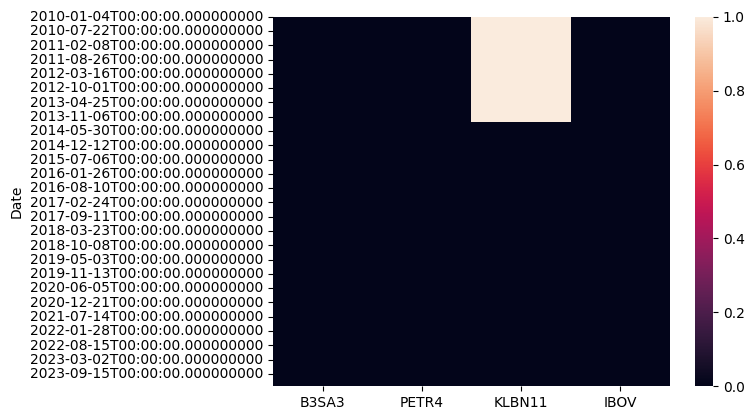

In [88]:
sns.heatmap(acoes_df.isnull())

In [89]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2024-03-04,12.300000,40.080002,22.510000,128341.0
2024-03-05,12.190000,39.959999,22.299999,128098.0
2024-03-06,12.250000,40.840000,22.150000,128890.0


### Visualização dos dados 

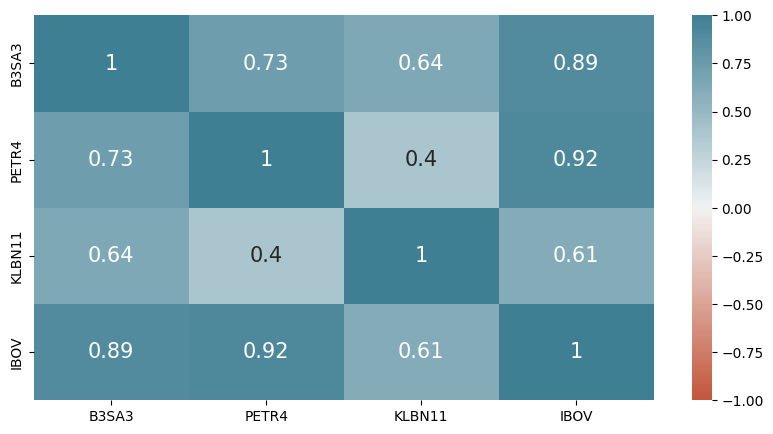

In [90]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [91]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [92]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2024-03-04,3.784615,2.590821,1.916723,2.656009
2024-03-05,3.750769,2.583064,1.898842,2.650980
2024-03-06,3.769231,2.639948,1.886069,2.667370


In [93]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [94]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [95]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [96]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [97]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')



[*********************100%%**********************]  1 of 1 completed


In [98]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()

# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [99]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [100]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [101]:
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variacao'] = ((df['Close'].shift(-7) - df['Close']) / df['Close'])*100

# Definir a variável alvo com base na variação percentual
df['Subida'] = df['Variacao'].apply(lambda x: 1 if x > 1 else 0)

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,upper_band_bollinger,lower_band_bollinger,EMA9,...,EMA200,RSI_14,MACD,Signal,Variacao,Subida,weekday,day,month,quarter
0,2015-01-02,3.270000,3.270000,3.150000,3.170000,2.279344,21734100,0.000000,0.000000,3.170000,...,3.170000,0.000000,0.000000,0.000000,-4.521582,0,5,2,1,1
1,2015-01-05,3.143333,3.153333,3.056666,3.083333,2.217028,34790100,0.000000,0.000000,3.121852,...,3.126450,0.000000,-0.006914,-0.001383,0.108100,0,1,5,1,1
2,2015-01-06,3.066666,3.113333,3.033333,3.113333,2.238599,49214700,0.000000,0.000000,3.118360,...,3.122034,0.000000,-0.009858,-0.003078,-1.284795,0,2,6,1,1
3,2015-01-07,3.133333,3.283333,3.126666,3.236666,2.327279,24006600,0.000000,0.000000,3.158437,...,3.151123,0.000000,-0.002215,-0.002905,-2.162717,0,3,7,1,1
4,2015-01-08,3.296666,3.300000,3.190000,3.193333,2.296121,22967700,0.000000,0.000000,3.168818,...,3.159735,0.000000,0.000343,-0.002256,-6.263043,0,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,2024-03-04,12.420000,12.440000,12.260000,12.300000,12.300000,32530100,13.444275,12.201724,12.590606,...,13.132738,32.061076,-0.260912,-0.250302,0.000000,0,1,4,3,1
2279,2024-03-05,12.390000,12.410000,12.110000,12.190000,12.190000,41616100,13.433454,12.114545,12.510484,...,13.123357,35.744682,-0.278388,-0.255919,0.000000,0,2,5,3,1
2280,2024-03-06,12.280000,12.360000,12.140000,12.250000,12.250000,64366000,13.416493,12.049507,12.458388,...,13.114667,40.178584,-0.284121,-0.261560,0.000000,0,3,6,3,1
2281,2024-03-07,12.240000,12.400000,12.110000,12.320000,12.320000,43360500,13.356955,12.020044,12.430710,...,13.106760,40.969168,-0.279791,-0.265206,0.000000,0,4,7,3,1


## Tratamento de dados para Predição de ativos

### Pré-processamento dos dados para predição 

In [102]:
ticker

'B3SA3.SA'

In [103]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [104]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [105]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
#features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200']
#features_indicators=[]
#features_indicators=['EMA9', 'EMA20']

acoes_df = df[['Close']+features_indicators]  
acoes_df_normalized = acoes_df / acoes_df.max().values
acoes_df_normalized.describe()
acoes_df['ds']=df['Date']

/tmp/ipykernel_5268/1102800203.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
def comput_features(data_array, lookback = 1, features_indicators=[]):

    df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    #df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])

    df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df)
    # Calcula as EMAs de 9 e 20 períodos
    df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    df_['EMA200'] = df_['Close'].ewm(span=200).mean()

    # Calculate RSI (14-period)
    df_['RSI_14'] = calculate_rsi(df, window=14)

    # Calculate MACD (12, 26, 9)
    df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)

    
    df_.iloc[:]= np.nan_to_num(df_.values)

    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    for columns in df_.columns:
        df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return df_, X_features

df_,_=comput_features(df['Close'].values)
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]

In [106]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        #X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        #X +=[X_inputs]
        X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        y += [data[['Close']].values[win:win+pred_days]]
    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y=np.vstack(y)
    return X, y

X, y = windowing(df,features_indicators)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2260, 32)
y shape (2260, 1)
Last Date 2024-03-08T00:00:00.000000000


In [107]:
features_scaler = MinMaxScaler()
X=features_scaler.fit_transform(X)

scaler = MinMaxScaler()
y=scaler.fit_transform(y)

In [109]:
'''lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        X += [data[win-lookback:win]]
        y += [data[win:win+pred_days]]  
    X=np.vstack(X)
    y=np.array(y)
    return X, y

X, y = windowing(acoes_df_norm['y'].values)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])'''

'lookback = 23  # number of past days used to predict the future value\npred_days = 1  # number of future days to predict\ndef windowing(data):\n    X = []\n    y = []\n    x_time = []\n    for win in np.arange(lookback,len(data),1):\n        X += [data[win-lookback:win]]\n        y += [data[win:win+pred_days]]  \n    X=np.vstack(X)\n    y=np.array(y)\n    return X, y\n\nX, y = windowing(acoes_df_norm[\'y\'].values)\ndate_time=acoes_df[\'ds\'][lookback:]\n#date_time =date_time_old + datetime.timedelta(days=pred_days)\n\nprint("X shape",X.shape)\nprint("y shape",y.shape)\nprint("Last Date",date_time.values[-1])'

In [110]:
# separa os dados em Treino e Teste
def split_data(X,y,date_time,factor=0.70):
    nits=round(len(X)*factor)
    X_train=X[:nits,:]
    nit_test= np.max(X_train.shape) -1
    X_test=X[nit_test:,:]

    y_train=y[:nits]
    y_test =y[nit_test:]
    
    T_train=date_time[:nits]
    T_test =date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [111]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Modelos de rede neural

### CNN_LSTM

In [112]:
X.shape

(2260, 32)

In [113]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 14, 64)            384       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 448)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                14368     
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                          

### MultiLayer Perceptron

In [114]:
model_name= "MLP"
# Camada de entrada
input_data = Input(shape=(X.shape[1],))

dense_output = Dense(64, activation='relu')(input_data)
#dense_output=Dropout(0.2)(dense_output)

dense_output = Dense(128, activation='relu')(dense_output)
dense_output=Dropout(0.2)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(1, activation='linear')(dense_output)


model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name=model_name
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 10561 (41.25 KB)
Trainable params: 10561 (41.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (LSTM) 

In [115]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, activation='relu', return_sequences=False)(input_data)
Dropout_output = Dropout(0.2)(lstm_output)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (GRU) 

In [116]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64, activation='relu')(input_data)
Dropout_output = Dropout(0.2)(GRU_output)
output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM with Attention layer

In [117]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [118]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_data)
x = Dropout(0.2)(x)
x = Attention(64)(x)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 32, 64)            16896     
                                                                 
 dropout_9 (Dropout)         (None, 32, 64)            0         
                                                                 
 attention_1 (Attention)     (None, 64)                4225      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21186 (82.76 KB)
Trainable params: 21186 (82.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Hiperparâmetros para de treinamento

**Metrics and Loss Functions**  

In [119]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [120]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [121]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200


 1/42 [..............................] - ETA: 14s - loss: 0.1180 - NRMSE: 0.6565
Epoch 1: val_loss improved from inf to 0.00263, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 10ms/step - loss: 0.7430 - NRMSE: 0.7046 - val_loss: 0.0026 - val_NRMSE: 0.9560 - lr: 0.0500
Epoch 2/200
 1/42 [..............................] - ETA: 0s - loss: 0.0066 - NRMSE: 0.9189
Epoch 2: val_loss did not improve from 0.00263
42/42 [==============================] - 0s 1ms/step - loss: 0.0079 - NRMSE: 0.9134 - val_loss: 0.0101 - val_NRMSE: 0.9066 - lr: 0.0500
Epoch 3/200
 1/42 [..............................] - ETA: 0s - loss: 0.0089 - NRMSE: 0.9054
Epoch 3: val_loss improved from 0.00263 to 0.00179, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 8ms/step - loss: 0.0065 - NRMSE: 0.9219 - val_loss: 0.0018 - val_NRMSE: 0.9628 - lr: 0.0500
Epoch 4/200
 1/42 [..............................] - ETA: 0s - loss: 0.0107 - NRMSE: 0.8965
Epoch 4: val_loss did not improve from 0.00179
42/42 [==============================] - 0s 2ms/step - loss: 0.0056 - NRMSE: 0.9279 - val_loss: 0.0151 - val_NRMSE: 0.8831 - lr: 0.0500
Epoch 5/200
 1/42 [..............................] - ETA: 0s - loss: 0.0065 - NRMSE: 0.9194
Epoch 5: val_loss did not improve from 0.00179
42/42 [==============================] - 0s 2ms/step - loss: 0.0043 - NRMSE: 0.9365 - val_loss: 0.0064 - val_NRMSE: 0.9252 - lr: 0.0500
Epoch 6/200
 1/42 [..............................] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9439
Epoch 6: val_loss improved from 0.00179 to 0.00078, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 10ms/step - loss: 0.0038 - NRMSE: 0.9402 - val_loss: 7.7754e-04 - val_NRMSE: 0.9731 - lr: 0.0500
Epoch 7/200
 1/42 [..............................] - ETA: 0s - loss: 9.7771e-04 - NRMSE: 0.9687
Epoch 7: val_loss did not improve from 0.00078
42/42 [==============================] - 0s 2ms/step - loss: 0.0044 - NRMSE: 0.9366 - val_loss: 0.0025 - val_NRMSE: 0.9549 - lr: 0.0500
Epoch 8/200
 1/42 [..............................] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9594
Epoch 8: val_loss did not improve from 0.00078
42/42 [==============================] - 0s 2ms/step - loss: 0.0038 - NRMSE: 0.9411 - val_loss: 0.0106 - val_NRMSE: 0.9045 - lr: 0.0500
Epoch 9/200
 1/42 [..............................] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9399
Epoch 9: val_loss did not improve from 0.00078
42/42 [==============================] - 0s 2ms/step - loss: 0.0029 - NRMSE: 0.9486 - val_loss: 8.7772e-04 - val_NRMSE: 0.9721 - lr: 0.0500
Epoch 10/200
 1/42 [......

INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 9ms/step - loss: 0.0023 - NRMSE: 0.9537 - val_loss: 7.4611e-04 - val_NRMSE: 0.9726 - lr: 0.0500
Epoch 12/200
 1/42 [..............................] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9662
Epoch 12: val_loss improved from 0.00075 to 0.00071, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 9ms/step - loss: 0.0018 - NRMSE: 0.9581 - val_loss: 7.0756e-04 - val_NRMSE: 0.9746 - lr: 0.0100
Epoch 13/200
 1/42 [..............................] - ETA: 0s - loss: 4.7639e-04 - NRMSE: 0.9782
Epoch 13: val_loss improved from 0.00071 to 0.00066, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 10ms/step - loss: 0.0020 - NRMSE: 0.9568 - val_loss: 6.5648e-04 - val_NRMSE: 0.9753 - lr: 0.0100
Epoch 14/200
 1/42 [..............................] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9622
Epoch 14: val_loss did not improve from 0.00066
42/42 [==============================] - 0s 2ms/step - loss: 0.0020 - NRMSE: 0.9569 - val_loss: 0.0014 - val_NRMSE: 0.9651 - lr: 0.0100
Epoch 15/200
 1/42 [..............................] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9611
Epoch 15: val_loss improved from 0.00066 to 0.00060, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 8ms/step - loss: 0.0020 - NRMSE: 0.9572 - val_loss: 5.9855e-04 - val_NRMSE: 0.9762 - lr: 0.0100
Epoch 16/200
 1/42 [..............................] - ETA: 0s - loss: 0.0058 - NRMSE: 0.9236
Epoch 16: val_loss improved from 0.00060 to 0.00053, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 8ms/step - loss: 0.0022 - NRMSE: 0.9543 - val_loss: 5.2840e-04 - val_NRMSE: 0.9771 - lr: 0.0100
Epoch 17/200
 1/42 [..............................] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9633
Epoch 17: val_loss improved from 0.00053 to 0.00053, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 9ms/step - loss: 0.0018 - NRMSE: 0.9591 - val_loss: 5.2682e-04 - val_NRMSE: 0.9772 - lr: 0.0100
Epoch 18/200
 1/42 [..............................] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9669
Epoch 18: val_loss did not improve from 0.00053
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - NRMSE: 0.9581 - val_loss: 6.4124e-04 - val_NRMSE: 0.9756 - lr: 0.0100
Epoch 19/200
 1/42 [..............................] - ETA: 0s - loss: 7.8632e-04 - NRMSE: 0.9720
Epoch 19: val_loss did not improve from 0.00053
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - NRMSE: 0.9587 - val_loss: 0.0013 - val_NRMSE: 0.9665 - lr: 0.0100
Epoch 20/200
 1/42 [..............................] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9336
Epoch 20: val_loss did not improve from 0.00053
42/42 [==============================] - 0s 1ms/step - loss: 0.0017 - NRMSE: 0.9599 - val_loss: 0.0014 - val_NRMSE: 0.9651 - lr: 0.0100
Epoch 21/200
 1/42 [.

INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 8ms/step - loss: 0.0019 - NRMSE: 0.9581 - val_loss: 5.2440e-04 - val_NRMSE: 0.9774 - lr: 0.0020
Epoch 23/200
 1/42 [..............................] - ETA: 0s - loss: 8.6273e-04 - NRMSE: 0.9706
Epoch 23: val_loss did not improve from 0.00052
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - NRMSE: 0.9581 - val_loss: 5.3683e-04 - val_NRMSE: 0.9773 - lr: 0.0020
Epoch 24/200
 1/42 [..............................] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9598
Epoch 24: val_loss did not improve from 0.00052
42/42 [==============================] - 0s 1ms/step - loss: 0.0018 - NRMSE: 0.9594 - val_loss: 7.2408e-04 - val_NRMSE: 0.9744 - lr: 0.0020
Epoch 25/200
 1/42 [..............................] - ETA: 0s - loss: 4.4987e-04 - NRMSE: 0.9788
Epoch 25: val_loss improved from 0.00052 to 0.00051, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 8ms/step - loss: 0.0017 - NRMSE: 0.9606 - val_loss: 5.0994e-04 - val_NRMSE: 0.9774 - lr: 0.0020
Epoch 26/200
32/42 [=====================>........] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9597
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 26: val_loss did not improve from 0.00051
42/42 [==============================] - 0s 2ms/step - loss: 0.0017 - NRMSE: 0.9599 - val_loss: 6.1883e-04 - val_NRMSE: 0.9760 - lr: 0.0020
Epoch 27/200
 1/42 [..............................] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9654
Epoch 27: val_loss did not improve from 0.00051
42/42 [==============================] - 0s 1ms/step - loss: 0.0017 - NRMSE: 0.9606 - val_loss: 5.9447e-04 - val_NRMSE: 0.9764 - lr: 4.0000e-04
Epoch 28/200
 1/42 [..............................] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9568
Epoch 28: val_loss did not improve from 0.00051
42/42 [==============================] - 0s 1ms/step - loss: 0.0015 - NRMSE

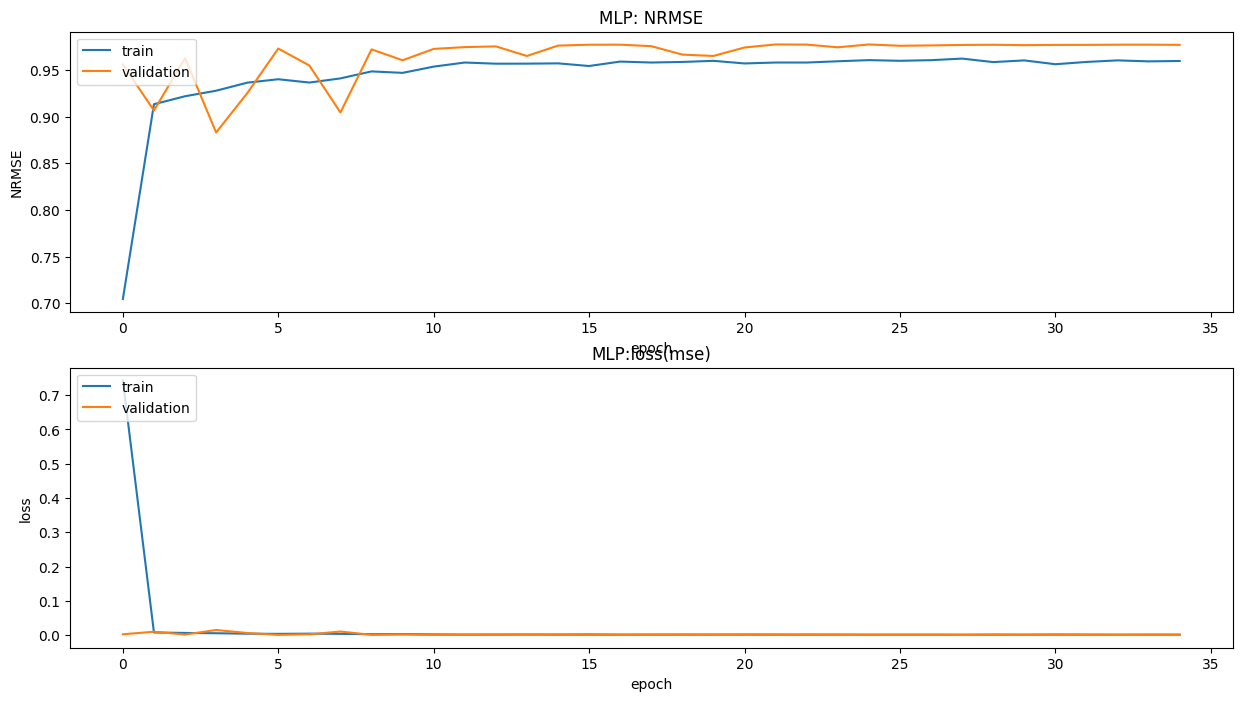

Training model : models/model_GRU_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0493 - NRMSE: 0.7943
Epoch 1: val_loss improved from inf to 0.01890, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 2s 36ms/step - loss: 0.0452 - NRMSE: 0.8044 - val_loss: 0.0189 - val_NRMSE: 0.8834 - lr: 0.0500
Epoch 2/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0068 - NRMSE: 0.9197
Epoch 2: val_loss improved from 0.01890 to 0.00138, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 23ms/step - loss: 0.0066 - NRMSE: 0.9205 - val_loss: 0.0014 - val_NRMSE: 0.9638 - lr: 0.0500
Epoch 3/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0058 - NRMSE: 0.9258
Epoch 3: val_loss improved from 0.00138 to 0.00108, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 22ms/step - loss: 0.0055 - NRMSE: 0.9278 - val_loss: 0.0011 - val_NRMSE: 0.9694 - lr: 0.0500
Epoch 4/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0048 - NRMSE: 0.9323
Epoch 4: val_loss did not improve from 0.00108
42/42 [==============================] - 0s 6ms/step - loss: 0.0047 - NRMSE: 0.9325 - val_loss: 0.0020 - val_NRMSE: 0.9618 - lr: 0.0500
Epoch 5/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9352
Epoch 5: val_loss did not improve from 0.00108
42/42 [==============================] - 0s 5ms/step - loss: 0.0043 - NRMSE: 0.9356 - val_loss: 0.0062 - val_NRMSE: 0.9303 - lr: 0.0500
Epoch 6/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0043 - NRMSE: 0.9359
Epoch 6: val_loss did not improve from 0.00108
42/42 [==============================] - 0s 5ms/step - loss: 0.0044 - NRMSE: 0.9349 - val_loss: 0.0013 - val_NRMSE: 0.9665 - lr: 0.0500
Epoch 7/200
40/42 [===================

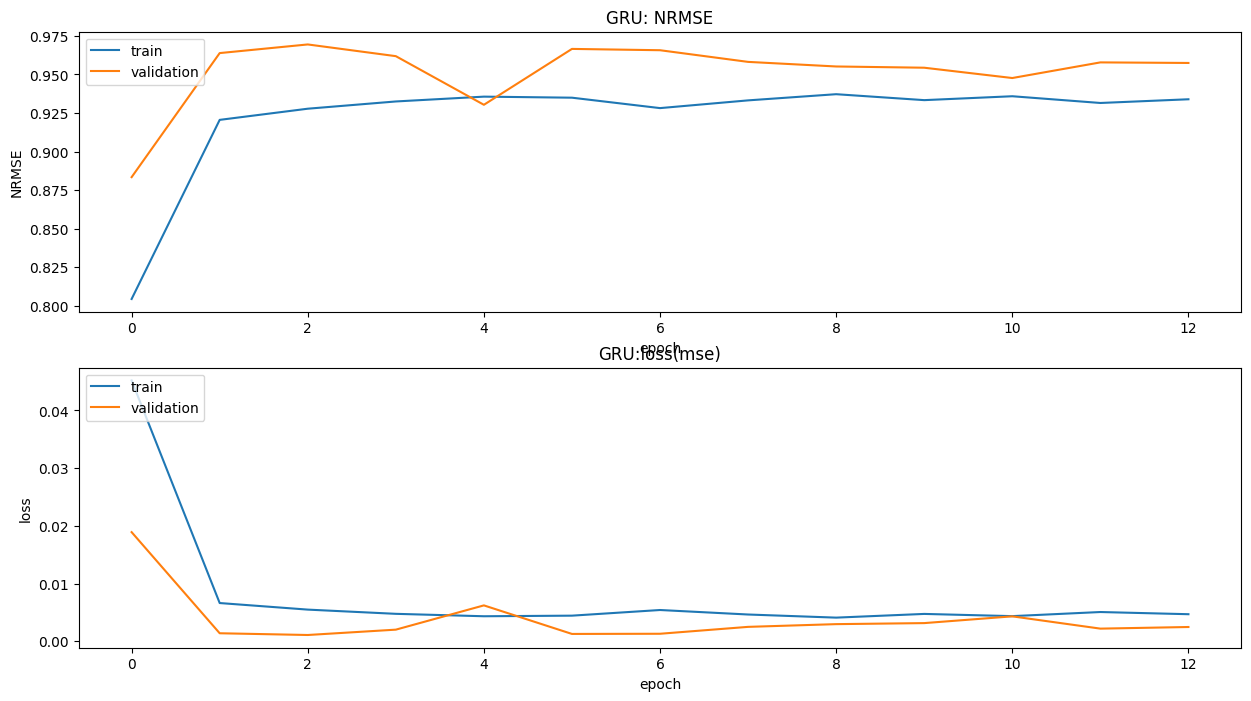

Training model : models/model_CNN_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
41/42 [============================>.] - ETA: 0s - loss: 4.4448 - NRMSE: 0.4690 
Epoch 1: val_loss improved from inf to 0.04191, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 13ms/step - loss: 4.3393 - NRMSE: 0.4790 - val_loss: 0.0419 - val_NRMSE: 0.8170 - lr: 0.0500
Epoch 2/200
 1/42 [..............................] - ETA: 0s - loss: 0.0108 - NRMSE: 0.8960
Epoch 2: val_loss improved from 0.04191 to 0.00483, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0057 - NRMSE: 0.9258 - val_loss: 0.0048 - val_NRMSE: 0.9385 - lr: 0.0500
Epoch 3/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9329
Epoch 3: val_loss improved from 0.00483 to 0.00156, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 12ms/step - loss: 0.0047 - NRMSE: 0.9331 - val_loss: 0.0016 - val_NRMSE: 0.9638 - lr: 0.0500
Epoch 4/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9453
Epoch 4: val_loss improved from 0.00156 to 0.00087, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 12ms/step - loss: 0.0031 - NRMSE: 0.9461 - val_loss: 8.6943e-04 - val_NRMSE: 0.9730 - lr: 0.0500
Epoch 5/200
42/42 [==============================] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9552
Epoch 5: val_loss did not improve from 0.00087
42/42 [==============================] - 0s 2ms/step - loss: 0.0021 - NRMSE: 0.9552 - val_loss: 0.0050 - val_NRMSE: 0.9325 - lr: 0.0500
Epoch 6/200
 1/42 [..............................] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9550
Epoch 6: val_loss did not improve from 0.00087
42/42 [==============================] - 0s 2ms/step - loss: 0.0016 - NRMSE: 0.9616 - val_loss: 0.0038 - val_NRMSE: 0.9402 - lr: 0.0500
Epoch 7/200
 1/42 [..............................] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9629
Epoch 7: val_loss did not improve from 0.00087
42/42 [==============================] - 0s 2ms/step - loss: 0.0018 - NRMSE: 0.9591 - val_loss: 0.0071 - val_NRMSE: 0.9181 - lr: 0.0500
Epoch 8/200
 1/42 [...............

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0012 - NRMSE: 0.9670 - val_loss: 7.3784e-04 - val_NRMSE: 0.9733 - lr: 0.0500
Epoch 10/200
42/42 [==============================] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9648    
Epoch 10: val_loss did not improve from 0.00074
42/42 [==============================] - 0s 2ms/step - loss: 0.0013 - NRMSE: 0.9648 - val_loss: 9.8998e-04 - val_NRMSE: 0.9690 - lr: 0.0500
Epoch 11/200
37/42 [=========================>....] - ETA: 0s - loss: 9.7563e-04 - NRMSE: 0.9692
Epoch 11: val_loss improved from 0.00074 to 0.00061, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 9.8829e-04 - NRMSE: 0.9691 - val_loss: 6.1338e-04 - val_NRMSE: 0.9756 - lr: 0.0500
Epoch 12/200
42/42 [==============================] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9642
Epoch 12: val_loss did not improve from 0.00061
42/42 [==============================] - 0s 2ms/step - loss: 0.0013 - NRMSE: 0.9642 - val_loss: 6.5897e-04 - val_NRMSE: 0.9746 - lr: 0.0500
Epoch 13/200
42/42 [==============================] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9639
Epoch 13: val_loss did not improve from 0.00061
42/42 [==============================] - 0s 2ms/step - loss: 0.0014 - NRMSE: 0.9639 - val_loss: 6.3711e-04 - val_NRMSE: 0.9751 - lr: 0.0500
Epoch 14/200
41/42 [============================>.] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9667    
Epoch 14: val_loss did not improve from 0.00061
42/42 [==============================] - 0s 2ms/step - loss: 0.0012 - NRMSE: 0.9668 - val_loss: 0.0012 - val_NRMSE: 0.9651 - lr: 0.0500
Epoch 15/200

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 9.4324e-04 - NRMSE: 0.9701 - val_loss: 5.9094e-04 - val_NRMSE: 0.9761 - lr: 0.0100
Epoch 18/200
 1/42 [..............................] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9553
Epoch 18: val_loss did not improve from 0.00059
42/42 [==============================] - 0s 2ms/step - loss: 8.2356e-04 - NRMSE: 0.9720 - val_loss: 6.1396e-04 - val_NRMSE: 0.9752 - lr: 0.0100
Epoch 19/200
 1/42 [..............................] - ETA: 0s - loss: 5.1260e-04 - NRMSE: 0.9774
Epoch 19: val_loss improved from 0.00059 to 0.00056, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0010 - NRMSE: 0.9686 - val_loss: 5.6219e-04 - val_NRMSE: 0.9765 - lr: 0.0100
Epoch 20/200
38/42 [==========================>...] - ETA: 0s - loss: 8.9091e-04 - NRMSE: 0.9710
Epoch 20: val_loss did not improve from 0.00056
42/42 [==============================] - 0s 2ms/step - loss: 8.7908e-04 - NRMSE: 0.9712 - val_loss: 5.8110e-04 - val_NRMSE: 0.9764 - lr: 0.0100
Epoch 21/200
41/42 [============================>.] - ETA: 0s - loss: 8.2566e-04 - NRMSE: 0.9718
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 21: val_loss did not improve from 0.00056
42/42 [==============================] - 0s 2ms/step - loss: 8.2195e-04 - NRMSE: 0.9719 - val_loss: 5.7738e-04 - val_NRMSE: 0.9759 - lr: 0.0100
Epoch 22/200
39/42 [==========================>...] - ETA: 0s - loss: 8.9110e-04 - NRMSE: 0.9706
Epoch 22: val_loss improved from 0.00056 to 0.00055, saving model to models/model_CNN_LSTM_stock_B3SA3_loo

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 22ms/step - loss: 8.6725e-04 - NRMSE: 0.9711 - val_loss: 5.4595e-04 - val_NRMSE: 0.9766 - lr: 0.0020
Epoch 23/200
 1/42 [..............................] - ETA: 0s - loss: 6.0894e-04 - NRMSE: 0.9753
Epoch 23: val_loss did not improve from 0.00055
42/42 [==============================] - 0s 2ms/step - loss: 8.2302e-04 - NRMSE: 0.9719 - val_loss: 5.9758e-04 - val_NRMSE: 0.9754 - lr: 0.0020
Epoch 24/200
30/42 [====================>.........] - ETA: 0s - loss: 8.2782e-04 - NRMSE: 0.9719
Epoch 24: val_loss improved from 0.00055 to 0.00054, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 14ms/step - loss: 8.4255e-04 - NRMSE: 0.9717 - val_loss: 5.4339e-04 - val_NRMSE: 0.9767 - lr: 0.0020
Epoch 25/200
 1/42 [..............................] - ETA: 0s - loss: 3.3094e-04 - NRMSE: 0.9818
Epoch 25: val_loss did not improve from 0.00054
42/42 [==============================] - 0s 2ms/step - loss: 9.0068e-04 - NRMSE: 0.9710 - val_loss: 7.3737e-04 - val_NRMSE: 0.9727 - lr: 0.0020
Epoch 26/200
 1/42 [..............................] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9590
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 26: val_loss did not improve from 0.00054
42/42 [==============================] - 0s 2ms/step - loss: 8.6197e-04 - NRMSE: 0.9712 - val_loss: 6.3123e-04 - val_NRMSE: 0.9747 - lr: 0.0020
Epoch 27/200
 1/42 [..............................] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9658
Epoch 27: val_loss did not improve from 0.00054
42/42 [==============================] - 0s 2ms/step - loss: 8

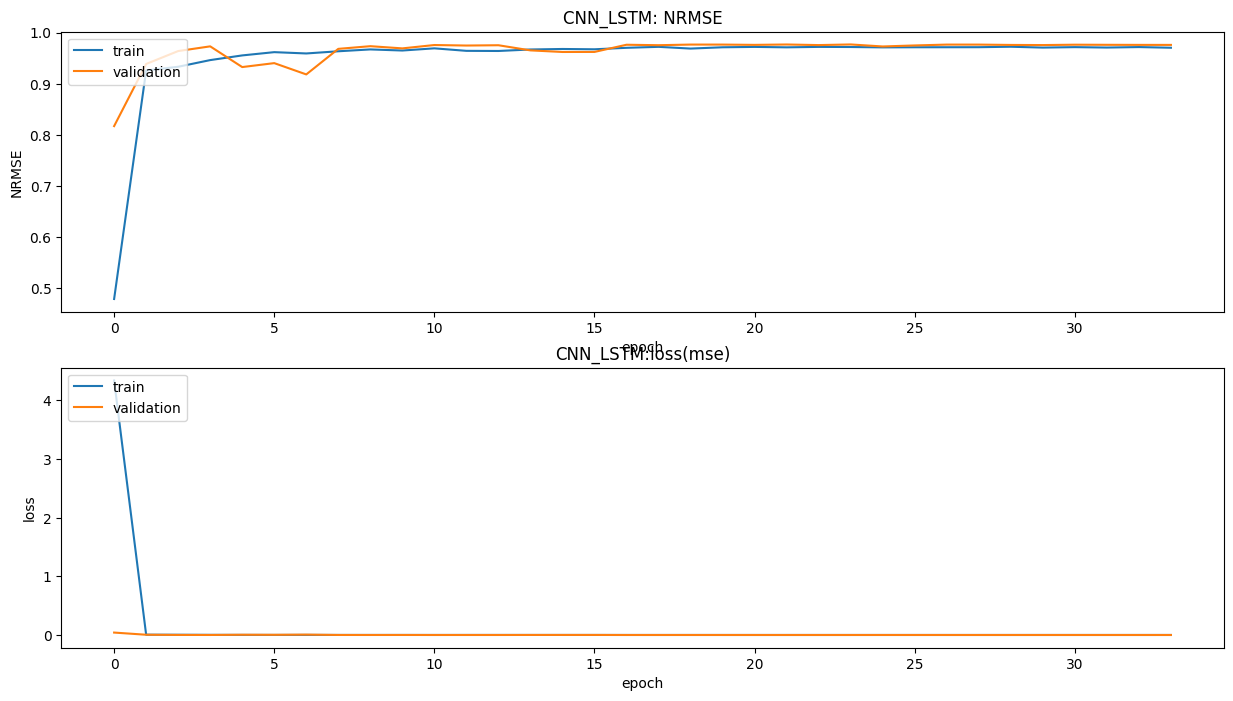

Training model : models/model_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
42/42 [==============================] - ETA: 0s - loss: 2626804.0000 - NRMSE: -261.7197
Epoch 1: val_loss improved from inf to 0.09723, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 2s 29ms/step - loss: 2626804.0000 - NRMSE: -261.7197 - val_loss: 0.0972 - val_NRMSE: 0.7831 - lr: 0.0500
Epoch 2/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0393 - NRMSE: 0.8056
Epoch 2: val_loss did not improve from 0.09723
42/42 [==============================] - 0s 6ms/step - loss: 0.0397 - NRMSE: 0.8042 - val_loss: 0.2287 - val_NRMSE: 0.6702 - lr: 0.0500
Epoch 3/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0370 - NRMSE: 0.8113
Epoch 3: val_loss did not improve from 0.09723
42/42 [==============================] - 0s 6ms/step - loss: 0.0392 - NRMSE: 0.8059 - val_loss: 0.1457 - val_NRMSE: 0.7353 - lr: 0.0500
Epoch 4/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0361 - NRMSE: 0.8131
Epoch 4: val_loss did not improve from 0.09723
42/42 [==============================] - 0s 6ms/step - loss: 0.0367 - NRMSE: 0.8116 - val_loss: 0.1293 - val_NRMSE: 0.7514 - lr: 0.0500
Epoch 5/200
42/42 [==========

INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 24ms/step - loss: 0.0319 - NRMSE: 0.8250 - val_loss: 0.0893 - val_NRMSE: 0.7903 - lr: 0.0500
Epoch 6/200
34/42 [=======================>......] - ETA: 0s - loss: 0.0305 - NRMSE: 0.8287
Epoch 6: val_loss improved from 0.08925 to 0.05883, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 24ms/step - loss: 0.0303 - NRMSE: 0.8291 - val_loss: 0.0588 - val_NRMSE: 0.8254 - lr: 0.0500
Epoch 7/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0275 - NRMSE: 0.8368
Epoch 7: val_loss improved from 0.05883 to 0.04863, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 23ms/step - loss: 0.0281 - NRMSE: 0.8346 - val_loss: 0.0486 - val_NRMSE: 0.8424 - lr: 0.0500
Epoch 8/200
13/42 [========>.....................] - ETA: 0s - loss: 0.0250 - NRMSE: 0.8440

KeyboardInterrupt: 

In [122]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validação

In [ ]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [ ]:
checkpoint_filepath

'models/model_LSTM_AT_stock_B3SA3_lookback_23'

In [ ]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x7f19594d2590>,
 'GRU': <keras.src.engine.functional.Functional at 0x7f1963118760>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x7f194010c730>,
 'LSTM': <keras.src.engine.functional.Functional at 0x7f19407d6c80>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x7f19406c73a0>}

In [ ]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(acoes_df,features_indicators)

X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

11/11 [==============================] - 0s 689us/step
MLP NN R2: nan
11/11 [==============================] - 0s 2ms/step
GRU NN R2: nan


/tmp/ipykernel_5268/1006071559.py:4: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_5268/1006071559.py:4: RuntimeWarning:

invalid value encountered in scalar divide



11/11 [==============================] - 0s 945us/step
CNN_LSTM NN R2: nan
11/11 [==============================] - 0s 2ms/step
LSTM NN R2: nan


/tmp/ipykernel_5268/1006071559.py:4: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_5268/1006071559.py:4: RuntimeWarning:

invalid value encountered in scalar divide



11/11 [==============================] - 0s 3ms/step
LSTM_AT NN R2: nan


/tmp/ipykernel_5268/1006071559.py:4: RuntimeWarning:

invalid value encountered in scalar divide



In [ ]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [ ]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Geração de valores para predições futuras

In [ ]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-03-08
Estamos Fornecendo dados até o dia : 2024-03-07
O modelo fará previsões até o dia:  2024-03-14


In [ ]:
comput_features(NN_predictions,lookback, features_indicators)

NameError: name 'NN_predictions' is not defined

In [ ]:
y_test[:-1].shape


(339, 1)

In [ ]:
dias_antes

-1

In [ ]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=2

    if dias_antes == 0:
        NN_predictions=y_test.copy()

        X_inputs=comput_features(y_test,lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(y_test[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    for k in range(n_steps):
        
        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

(23,)
(9,)
1/1 [==============================] - 0s 28ms/step


(23,)
(9,)
1/1 [==============================] - 0s 17ms/step
(23,)
(9,)
(23,)
(9,)
1/1 [==============================] - 0s 123ms/step
(23,)
(9,)
1/1 [==============================] - 0s 20ms/step
(23,)
(9,)
(23,)
(9,)
1/1 [==============================] - 0s 48ms/step
(23,)
(9,)
1/1 [==============================] - 0s 17ms/step
(23,)
(9,)
(23,)
(9,)


1/1 [==============================] - 0s 126ms/step
(23,)
(9,)
1/1 [==============================] - 0s 20ms/step
(23,)
(9,)
(23,)
(9,)


1/1 [==============================] - 0s 167ms/step
(23,)
(9,)
1/1 [==============================] - 0s 65ms/step
(23,)
(9,)


In [ ]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

Using ARIMA model


In [ ]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [ ]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

,Data,pred,Variacao,Subida
331,2024-02-23,12.450000,-1.606424,0
332,2024-02-26,12.480000,0.240382,1
333,2024-02-27,12.750000,2.117651,1
334,2024-02-28,12.580000,-1.351352,0
335,2024-02-29,12.830000,1.948558,1
336,2024-03-01,12.420000,-3.301126,0
337,2024-03-04,12.300000,-0.975609,0
338,2024-03-05,12.190000,-0.902384,0
339,2024-03-06,12.250000,0.489799,1
340,2024-03-07,12.046184,-1.691956,0


In [ ]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

,Data,pred,Variacao,Subida
339,2024-03-06,12.25,0.489799,1


In [ ]:
result=pred_data_df.iloc[-1:,:]
result

,Data,pred,Variacao,Subida
340,2024-03-07,12.046184,-1.691956,0


In [ ]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-03-07 é de Descida, de -1.69% o valor predito é de: 12.05


In [ ]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 37ms/step


array([[12.046184]], dtype=float32)